In [1]:
#!pip install -q opencv-python #this module to use as computer vision
#!pip install -q pillow        # To manipulate pictures
#!pip install -q keras         # we use Keras as NN to make photo comparisons
#!pip install -q keras_vggface # Pre-trainned model VGGFace containing around 147M parameters
#!pip install -q scipy         # we will use it to calculate distance between resulted vectors

In [2]:
#!pip install -q plaidml
#PlaidML is a modules used as Backend for Keras it enables processing at your GPU
#Once installed dont forget to  run plaidml-setup  from command promt and follow steps to enable GPU backend
#You can skip this step and use CPU

In [3]:
#importing all modules we will need
import cv2
import numpy as np
import math
#!------ vvvvvvv comment section delow if you dont used PLAID as backend or if you use TensorFlow
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#!------^^^^^^^^^^
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from scipy.spatial.distance import cosine

Using plaidml.keras.backend backend.


In [4]:
path = 'faces_to_compare' #folder with photos for comparison

# we will use Cascade classifier from OpenCV to detect face and eyes. 
faceCascade = cv2.CascadeClassifier('haar_cascade.xml')
eyeCascade = cv2.CascadeClassifier('haarcascade_eye.xml')

In [5]:
myList = os.listdir(path)
images = []
names = []
for cl in myList:
    if os.path.splitext(cl)[1].lower() == '.jpg':
        #print(os.path.splitext(cl)[0])
        curImg = cv2.imread(f'{path}/{cl}')
        images.append(curImg)
        names.append(os.path.splitext(cl)[0])

In [6]:
def show_photos(photo_list):
    plt.figure(figsize=(12,4))
    ax = plt.gca()
    for idx, img in enumerate(photo_list):
        ax = plt.subplot(1, len(photo_list), idx +1)
        ax.imshow(images[idx])
        ax.set_title(names[idx])
    plt.show()

def area(loc):
    return loc[2]*loc[3]

def euclidean_distance(a, b):
    x1 = a[0]; y1 = a[1]
    x2 = b[0]; y2 = b[1]
    return math.sqrt(((x2 - x1) * (x2 - x1)) + ((y2 - y1) * (y2 - y1)))

Let's see photos we are going to compare. We have example where the same person has different look such as  hear color and length and also heavy makeup. And another person to compare the difference.

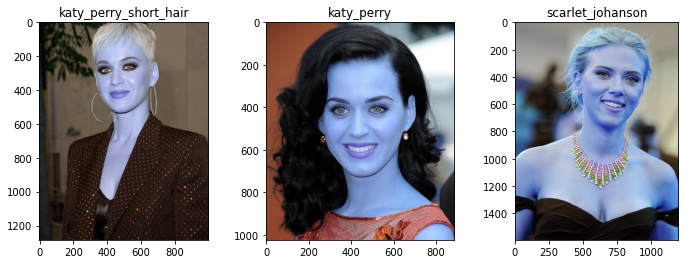

In [7]:
show_photos(images)

### Face aligment

This step is not nessesary as the VGGFace model was trained on diffrenet head tilt and rotation soit should be able to spot the features. But for the sake of fun lets recall school geomentry.

angle: 8.833414651218982 degree
angle: 2.573359463176839 degree
angle: 81.9092221280104 degree


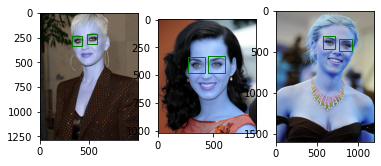

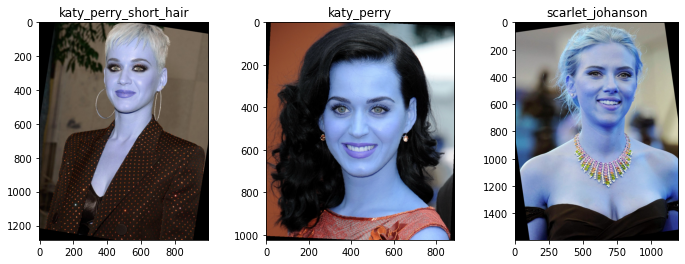

In [8]:
for idx, img in enumerate(images):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.blur(gray, (2,2))
    ax = plt.subplot(1, len(images), idx +1)
    # To use cascade method we need to covert in gray scale
    eyes = eyeCascade.detectMultiScale(gray, 1.5, 5)
    eyes = sorted(eyes, key=lambda x: x[2], reverse=True)[:2] # sort by width and take two widest
    #print(eyes)
    index = 0
    
    # eyes location given as coordinates of topleft corner and  width and height of the box
    for (x, y, w, h) in eyes:
       if index == 0:
          eye_1 = (x, y, w, h)
       elif index == 1:
          eye_2 = (x, y, w, h)
       eye_box = Rectangle((x, y), w, h, fill=False, color='green')
       ax.add_patch(eye_box)
       index = index + 1
    
    ax.imshow(images[idx])
    
    #we need to identify which eye is left/right so we know in which direction we need to rotate
    if eye_1[0] <= eye_2[0]:
       left_eye = eye_1
       right_eye = eye_2
    else:
       left_eye = eye_2
       right_eye = eye_1
    
    left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
    left_eye_x = left_eye_center[0]; left_eye_y = left_eye_center[1]

    right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
    right_eye_x = right_eye_center[0]; right_eye_y = right_eye_center[1]
    
    if left_eye_y < right_eye_y:
       point_3rd = (right_eye_x, left_eye_y)
       direction = -1 #rotate same direction to clock
    else:
       point_3rd = (left_eye_x, right_eye_y)
       direction = 1 #rotate inverse direction of clock
    
    a = euclidean_distance(left_eye_center, point_3rd)
    b = euclidean_distance(right_eye_center, left_eye_center)
    c = euclidean_distance(right_eye_center, point_3rd)
    
    cos_a = (b*b + c*c - a*a)/(2*b*c)
    angle = np.arccos(cos_a) # here we have radians
    #need to convert to degree
    angle = (angle * 180) / math.pi
    print("angle:", angle,"degree")
    
    if direction == -1:
        angle = 90 - angle
    else:
        angle *= -1

    
    new_img = Image.fromarray(img)
    images[idx] = np.array(new_img.rotate(angle))

show_photos(images)

Now we have all faces upright. We can rpoceed with face detection and extraction.

### Face detection and extraction

To detect face on the photo we will use same Cascade method. There are other methods to detect the face e.g MTCNN. Buth performace is way poor and wont serve for realtime face detection. At least on my MacBook Pro 2012 year :)

In [9]:
grays =[]
facesLoc=[]
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grays.append(gray)
    facesLoc.append(faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30),))

In [10]:
def highlight_faces(image, faces_box):
    plt.imshow(image)

    ax = plt.gca()

    # for each face, draw a rectangle based on coordinates
    for face in faces_box:
        #print(face)
        x, y, width, height = face
        face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
        ax.add_patch(face_border)
    plt.show()

Faces detected so we can match areas on photos now

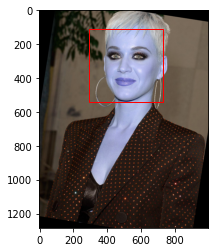

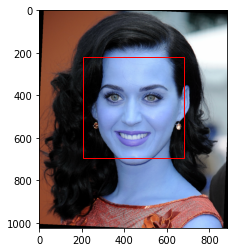

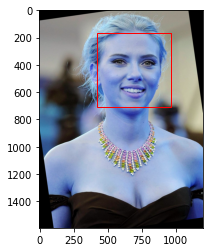

In [11]:
for img, loc in zip(images, facesLoc):
    highlight_faces(img, loc)

Here we prepare the fucntion to detect and extract faces. The extracted faces will be already prepared for the required size for the model.

In [12]:
def face_detection(img):
    facesLoc=[]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    facesLoc.append(faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30),))
    return facesLoc
    
def extract_face_from_image(images, required_size=(224, 224)):
    face_images = []
    
    for img in images:
        faces = face_detection(img)
        highlight_faces(img, faces[0])
        for face in faces:
            # extract the bounding box from the requested face
            x1, y1, width, height = face[0]
            x2, y2 = x1 + width, y1 + height
            #print(x1, y1, x2, y2)
            # extract the face
            face_boundary = img[y1:y2, x1:x2]

            # resize pixels to the model size
            face_image = Image.fromarray(face_boundary)
            face_image = face_image.resize(required_size)
            face_array = np.asarray(face_image)
            #face_array = face_array / 255
            face_images.append(face_array)
    return face_images

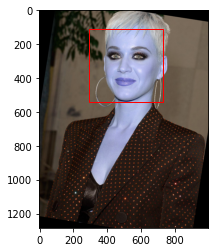

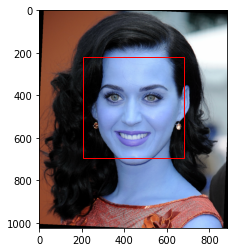

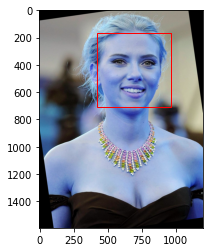

In [13]:
extracted_faces = extract_face_from_image(images)

New we have only extracted faces which we will use for comparison

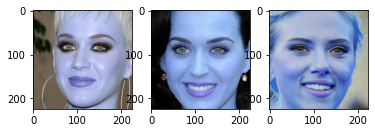

In [14]:
for idx, img in enumerate(extracted_faces):
    ax = plt.subplot(1, len(extracted_faces), idx +1)
    ax.imshow(extracted_faces[idx])
plt.show()

## VGGFace Model creation and execution

Since this model was trained already we  will disable top layers. Wen we will use predict for the samples we have the returning value will have a vector of 2048 parameter. <br>
To compare faces we will get vectors of each photo and  we will use COSINE distance from SciPy to identify similarity. Usualy if distance is <= 0.45 mostlikely person is the same.

In [15]:
def create_model():
    model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    return model    

def get_model_scores(faces, model):
    samples = np.asarray(faces, 'float32')
    # prepare the data for the model
    samples = preprocess_input(samples, version=2)
    # perform prediction
    return model.predict(samples)

In [16]:
%time
model = create_model()
model_vectors = get_model_scores(extracted_faces, model)

INFO:plaidml:Opening device "metal_nvidia_geforce_gt_750m.0"


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


Since we are using PlaidML backend which executes on GPU the prediction results are very quick.

In [17]:
distance = cosine(model_vectors[0], model_vectors[1])
print(distance)
if distance <= 0.45:
    print('Same person')
else:
    print('Different people')

0.359577476978302
Same person


As next step let's implement face recognition in realtime.